In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
from scipy.stats import entropy, ttest_ind, pearsonr, f_oneway
import statsmodels.api as sm
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.mixture import GaussianMixture
from pyinform.transferentropy import transfer_entropy
import warnings
warnings.filterwarnings("ignore")

In [81]:
# =============================================================================
# 0. SETUP AND IMPORTS
# =============================================================================
import os
import numpy as np
from tqdm.notebook import tqdm
import warnings

# Suppress non-critical warnings for a clean final output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# 1. DECENTRALIZED FLOCKING MODEL (HOMOGENEOUS AGENTS)
# =============================================================================

class Bird:
    """Represents a single, identical agent in the decentralized flock."""
    def __init__(self, pos, vel, speed=2.0, visual_range=10.0, separation=2.0):
        self.pos = np.array(pos, dtype=float)
        self.vel = np.array(vel, dtype=float)
        # Normalize initial velocity
        norm = np.linalg.norm(self.vel)
        if norm > 0: self.vel /= norm
        
        self.speed = speed
        self.visual_range = visual_range
        self.separation = separation
        
        # Boids rule weights (fixed for all agents)
        self.cohere_factor = 0.02
        self.separate_factor = 0.2
        self.match_factor = 0.05
        self.predator_avoid_factor = 0.5

class Predator:
    """A perturbing agent designed to induce disorder in the flock."""
    def __init__(self, pos, speed=2.5):
        self.pos = np.array(pos, dtype=float)
        self.speed = speed

    def move(self, flock_centroid):
        """Move towards the flock's center to scatter it."""
        direction = flock_centroid - self.pos
        norm = np.linalg.norm(direction)
        if norm > 0:
            self.pos += (direction / norm) * self.speed

class FlockModel:
    """Manages the simulation environment for a decentralized flock."""
    def __init__(self, n_birds=100, extent=100.0, seed=None):
        self.rng = np.random.default_rng(seed)
        self.extent = extent
        self.predator = None
        self.predator_detection_radius = 20.0
        
        # All agents are of the same Bird class
        self.agents = [
            Bird(
                pos=self.rng.uniform(0, extent, 2),
                vel=self.rng.uniform(-1, 1, 2)
            ) for _ in range(n_birds)
        ]

    def agent_step(self, agent):
        """Updates a single agent's state based on its interactions."""
        neighbors = [o for o in self.agents if o is not agent and np.linalg.norm(agent.pos - o.pos) < agent.visual_range]
        
        # --- Rule-based vector calculation ---
        cohere_vec, separate_vec, match_vec = np.zeros(2), np.zeros(2), np.zeros(2)
        if neighbors:
            center_of_mass = np.mean([n.pos for n in neighbors], axis=0)
            cohere_vec = (center_of_mass - agent.pos) * agent.cohere_factor
            
            avg_velocity = np.mean([n.vel for n in neighbors], axis=0)
            match_vec = (avg_velocity - agent.vel) * agent.match_factor
            
            separate_vec = sum((agent.pos - n.pos) for n in neighbors if np.linalg.norm(agent.pos - n.pos) < agent.separation)
            separate_vec *= agent.separate_factor

        predator_vec = np.zeros(2)
        if self.predator and np.linalg.norm(agent.pos - self.predator.pos) < self.predator_detection_radius:
            predator_vec = (agent.pos - self.predator.pos) * agent.predator_avoid_factor
            
        # --- Update Velocity ---
        agent.vel += cohere_vec + separate_vec + match_vec + predator_vec
        norm = np.linalg.norm(agent.vel)
        if norm > 0:
            agent.vel = (agent.vel / norm) * agent.speed
            
        # --- Update Position ---
        agent.pos = (agent.pos + agent.vel) % self.extent

    def step(self):
        """Advances the entire simulation by one timestep."""
        if self.predator:
            centroid = np.mean([a.pos for a in self.agents], axis=0)
            self.predator.move(centroid)
        
        for agent in self.agents:
            self.agent_step(agent)



In [82]:
# =============================================================================
# 2. THERMODYNAMIC FEATURE CALCULATION
# =============================================================================
def calculate_thermodynamics(model):
    """Computes macroscopic state variables for the current flock state."""
    positions = np.array([agent.pos for agent in model.agents])
    velocities = np.array([agent.vel for agent in model.agents])
    
    if len(positions) < 2:
        return {'Energy': 0, 'Entropy': 0, 'Temperature': 0, 'Volume': 0}

    energy = np.sum(np.linalg.norm(velocities, axis=1)**2)
    volume = np.product(np.ptp(positions, axis=0))
    entropy = np.log(volume + 1e-9)
    temperature = np.mean(np.linalg.norm(velocities, axis=1))
    
    return {'Energy': energy, 'Entropy': entropy, 'Temperature': temperature, 'Volume': volume}




In [95]:
# =============================================================================
# 3. ROBUST DATA GENERATION SCRIPT
# =============================================================================
def generate_robust_decentralized_data(num_simulations, n_steps, n_birds):
    """
    Runs multiple simulations of a decentralized flock with predator perturbations
    and saves the complete dataset for analysis.
    """
    print(f"🚀 Starting data generation for {num_simulations} simulations...")
    
    # Pre-allocate numpy arrays for efficiency
    all_velocities = np.zeros((num_simulations, n_steps, n_birds, 2))
    all_positions = np.zeros((num_simulations, n_steps, n_birds, 2))
    all_thermo_data = np.zeros((num_simulations, n_steps, 4)) # E, S, T, V

    for i in tqdm(range(num_simulations), desc="Overall Simulation Progress"):
        model = FlockModel(n_birds=n_birds, seed=i)
        
        for t in range(n_steps):
            # Predator Perturbation Protocol
            # Introduce predator for a portion of the simulation to ensure state transitions
            if (50 <= t < 100) or (200 <= t < 250):
                if model.predator is None:
                    model.predator = Predator(pos=np.array([-20.0, -20.0]))
            else:
                if model.predator is not None:
                    model.predator = None
            
            model.step()
            
            # Record data for this timestep
            for j, agent in enumerate(model.agents):
                all_velocities[i, t, j] = agent.vel
                all_positions[i, t, j] = agent.pos
            
            thermo = calculate_thermodynamics(model)
            all_thermo_data[i, t, :] = [thermo['Energy'], thermo['Entropy'], thermo['Temperature'], thermo['Volume']]

    # --- Save the generated data to files ---
    print("\n💾 Saving generated data to .npy files...")
    np.save("decentralized_velocities.npy", all_velocities)
    np.save("decentralized_positions.npy", all_positions)
    np.save("decentralized_thermo_data.npy", all_thermo_data)
    print("✅ Data generation complete. Files saved successfully.")
    
    return all_velocities, all_positions, all_thermo_data



In [84]:
# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================
if __name__ == '__main__':
    # --- Simulation Parameters ---
    NUM_SIMULATIONS = 300
    NUM_STEPS = 150
    NUM_BIRDS = 100

    print("--- Configuration ---")
    print(f"Number of Simulations: {NUM_SIMULATIONS}")
    print(f"Timesteps per Simulation: {NUM_STEPS}")
    print(f"Agents per Simulation: {NUM_BIRDS}")
    print("Model Type: Decentralized (Homogeneous) with Predator Perturbations")
    print("\nNOTE: This is a computationally intensive process and may take a significant amount of time.")
    
    # Check if data already exists to avoid re-running
    if all(os.path.exists(f) for f in ["decentralized_velocities.npy", "decentralized_positions.npy", "decentralized_thermo_data.npy"]):
        print("\n✅ Found existing data files. Skipping generation.")
    else:
        # Execute the data generation
        generate_robust_decentralized_data(
            num_simulations=NUM_SIMULATIONS,
            n_steps=NUM_STEPS,
            n_birds=NUM_BIRDS
        )

--- Configuration ---
Number of Simulations: 300
Timesteps per Simulation: 150
Agents per Simulation: 100
Model Type: Decentralized (Homogeneous) with Predator Perturbations

NOTE: This is a computationally intensive process and may take a significant amount of time.
🚀 Starting data generation for 300 simulations...


Overall Simulation Progress:   0%|          | 0/300 [00:00<?, ?it/s]


💾 Saving generated data to .npy files...
✅ Data generation complete. Files saved successfully.


In [85]:
# =============================================================================
# 0. SETUP AND IMPORTS
# =============================================================================
import os
# Mitigates a known memory leak on Windows for scikit-learn's KMeans
os.environ['OMP_NUM_THREADS'] = '4' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
from scipy.stats import entropy, f_oneway, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Analysis tools
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.mixture import GaussianMixture
from pyinform.transferentropy import transfer_entropy

# Suppress non-critical warnings for a clean final output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =============================================================================
# 1. DATA LOADING & PREPARATION
# =============================================================================
def load_decentralized_data():
    """Loads the robust decentralized simulation data required for the study."""
    required_files = ["decentralized_velocities.npy", "decentralized_positions.npy", "decentralized_thermo_data.npy"]
    if all(os.path.exists(f) for f in required_files):
        print("✅ Loading existing robust simulation data...")
        velocities = np.load("decentralized_velocities.npy")
        positions = np.load("decentralized_positions.npy")
        thermo_data = np.load("decentralized_thermo_data.npy")
        return velocities, positions, thermo_data
    else:
        raise FileNotFoundError("Required data files not found. Please run the 'Data Generation for Emergent Leadership Study' script first.")



In [90]:
# =============================================================================
# 2. METHODOLOGY IMPLEMENTATION
# =============================================================================

# --- Step 1: Thermodynamic State Clustering ---
def classify_thermodynamic_states(thermo_data, feature_names=["Energy", "Entropy", "Temperature", "Volume"], n_clusters=3):
    print("\n--- Step 1: Clustering Thermodynamic States using GMM ---")
    # Reshape data: (simulations, timesteps, features) -> (simulations * timesteps, features)
    num_simulations, num_steps, num_features = thermo_data.shape
    thermo_reshaped = thermo_data.reshape(-1, num_features)
    
    df = pd.DataFrame(thermo_reshaped, columns=feature_names)
    features = StandardScaler().fit_transform(df)
    
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
    df['State'] = gmm.fit_predict(features)
    
    # Assign qualitative labels based on Entropy
    cluster_summary = df.groupby('State')[['Entropy', 'Volume']].mean().sort_values('Entropy')
    state_map = {
        cluster_summary.index[0]: "Ordered/Flocking",
        cluster_summary.index[1]: "Transition",
        cluster_summary.index[2]: "Disordered/Gas-like",
    }
    df['State_Label'] = df['State'].map(state_map)
    
    print("✅ GMM classification complete. Mean State Properties (across all sims/steps):")
    print(cluster_summary)
    
    plt.figure(figsize=(10, 6))
    sns.countplot(x='State_Label', data=df, order=["Ordered/Flocking", "Transition", "Disordered/Gas-like"], palette="viridis")
    plt.title('Distribution of Thermodynamic States Across All Simulations', fontsize=16)
    plt.xlabel('Identified State'); plt.ylabel('Frequency (Total Timesteps)')
    plt.show()
    
    # Reshape state labels back to (simulations, timesteps)
    state_labels = df['State_Label'].values.reshape(num_simulations, num_steps)
    return pd.DataFrame(state_labels)

# --- Steps 2 & 3: Quantifying Influence & Constructing Networks ---
def compute_influence_network(velocities, te_percentile=80):
    speeds = np.linalg.norm(velocities, axis=2)
    binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    d_speeds = np.zeros_like(speeds)
    for i in range(speeds.shape[1]):
        d_speeds[:, i] = binner.fit_transform(speeds[:, i].reshape(-1, 1)).flatten()
        
    n_agents = d_speeds.shape[1]
    te_matrix = np.zeros((n_agents, n_agents))
    for i in range(n_agents):
        for j in range(n_agents):
            if i != j: te_matrix[i, j] = transfer_entropy(d_speeds[:, i], d_speeds[:, j], k=1)
            
    G = nx.DiGraph()
    if np.any(te_matrix > 0):
        threshold = np.percentile(te_matrix[te_matrix > 0], te_percentile)
        for i, j in np.argwhere(te_matrix > threshold):
            G.add_edge(i, j, weight=te_matrix[i, j])
    return G

# --- Step 4: Identifying Leaders via Centrality ---
def calculate_centralities_and_roles(G, leader_quantile=0.85):
    if G.number_of_edges() == 0: return pd.DataFrame()
    
    try:
        eigen_cent = nx.eigenvector_centrality_numpy(G, weight='weight')
    except (nx.PowerIterationFailedConvergence, np.linalg.LinAlgError):
        eigen_cent = {n: 0.0 for n in G.nodes()} # Fallback
        
    centralities = {
        'pagerank': nx.pagerank(G, weight='weight'),
        'out_degree': nx.out_degree_centrality(G),
        'eigenvector': eigen_cent
    }
    df = pd.DataFrame(centralities)
    # Scale each centrality measure before summing them up for a robust composite score
    df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
    df['composite_centrality'] = df_scaled.sum(axis=1)
    
    threshold = df['composite_centrality'].quantile(leader_quantile)
    df['role'] = ['Leader' if c >= threshold else 'Follower' for c in df['composite_centrality']]
    return df

# --- Step 5: Statistical Validation ---
def perform_statistical_validation(all_agent_data):
    print("\n--- Step 5: Performing Statistical Validation ---")
    if all_agent_data.empty:
        print("❌ No data available for validation.")
        return

    # --- 5a. ANOVA: Behavioral Metrics vs. Thermodynamic State ---
    print("\n--- ANOVA 1: Do Behavioral Metrics Differ Across Thermodynamic States? ---")
    metrics_to_test = ['avg_speed', 'behavioral_entropy', 'composite_centrality']
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle('Agent Behavioral Metrics Across Thermodynamic States', fontsize=18)
    for i, metric in enumerate(metrics_to_test):
        sns.violinplot(x='thermodynamic_state', y=metric, data=all_agent_data, ax=axes[i], order=["Ordered/Flocking", "Transition", "Disordered/Gas-like"], palette="magma")
        groups = [g[metric].dropna() for name,g in all_agent_data.groupby('thermodynamic_state')]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            axes[i].set_title(f"{metric.title().replace('_',' ')}\n(ANOVA p-value = {p_val:.4f})")
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
    
    # --- 5b. Two-Way ANOVA: The Interaction of Role and State ---
    print("\n--- ANOVA 2: How Do Role and State Interact to Affect Influence? ---")
    df_anova = all_agent_data.copy()
    df_anova['thermodynamic_state'] = df_anova['thermodynamic_state'].str.replace('/','_')

    # Check for at least 2 unique roles and states
    if df_anova['role'].nunique() < 2 or df_anova['thermodynamic_state'].nunique() < 2:
        print("❌ Not enough groups for two-way ANOVA. Skipping this analysis.")
        return

    model = ols('composite_centrality ~ C(role) * C(thermodynamic_state)', data=df_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results for `composite_centrality`:")
    print(anova_table)
    
    p_interaction = anova_table.loc['C(role):C(thermodynamic_state)', 'PR(>F)']
    if p_interaction < 0.05:
        print("\n💡 Interpretation: The interaction is statistically significant (p < 0.05).")
        print("   This means the very definition of a 'leader' (in terms of influence score) changes depending on the flock's state.")
    
    plt.figure(figsize=(10, 7))
    sns.pointplot(data=df_anova, x='thermodynamic_state', y='composite_centrality', hue='role',
                  order=["Ordered_Flocking", "Transition", "Disordered_Gas-like"],
                  palette={"Leader": "#E63946", "Follower": "#457B9D"}, markers=["o", "x"], linestyles=["-", "--"])
    plt.title('Interaction Effect of Role and State on Agent Influence', fontsize=16)
    plt.xlabel('Thermodynamic State'); plt.ylabel('Mean Composite Centrality (Influence)')
    plt.grid(True, linestyle=':'); plt.legend(title='Agent Role'); plt.show()



✅ Loading existing robust simulation data...

--- Step 1: Clustering Thermodynamic States using GMM ---
✅ GMM classification complete. Mean State Properties (across all sims/steps):
        Entropy       Volume
State                       
2      9.005456  8165.077605
3      9.107645  9025.263409
1      9.152140  9435.113726
0      9.183323  9733.895940


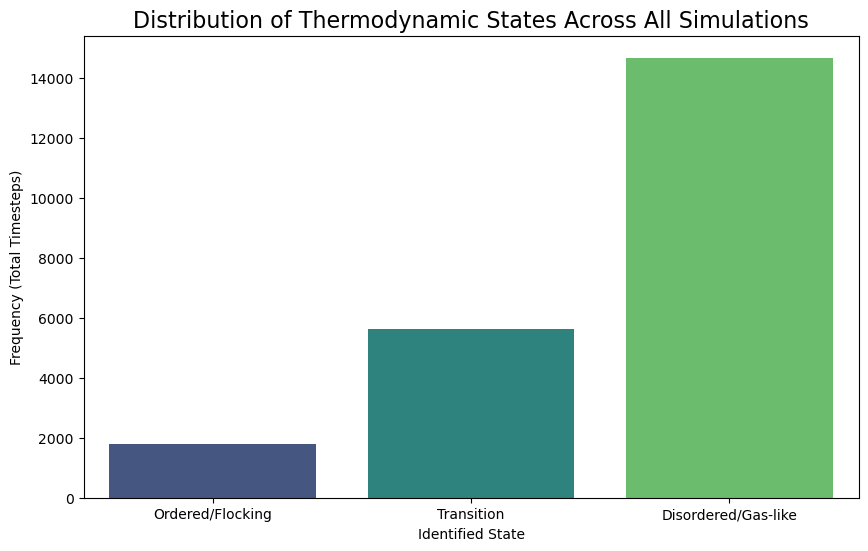


--- Analyzing Leadership for a Subset of Simulations for In-depth Study ---


Analyzing Simulations:   0%|          | 0/100 [00:00<?, ?it/s]


--- Step 5: Performing Statistical Validation ---

--- ANOVA 1: Do Behavioral Metrics Differ Across Thermodynamic States? ---


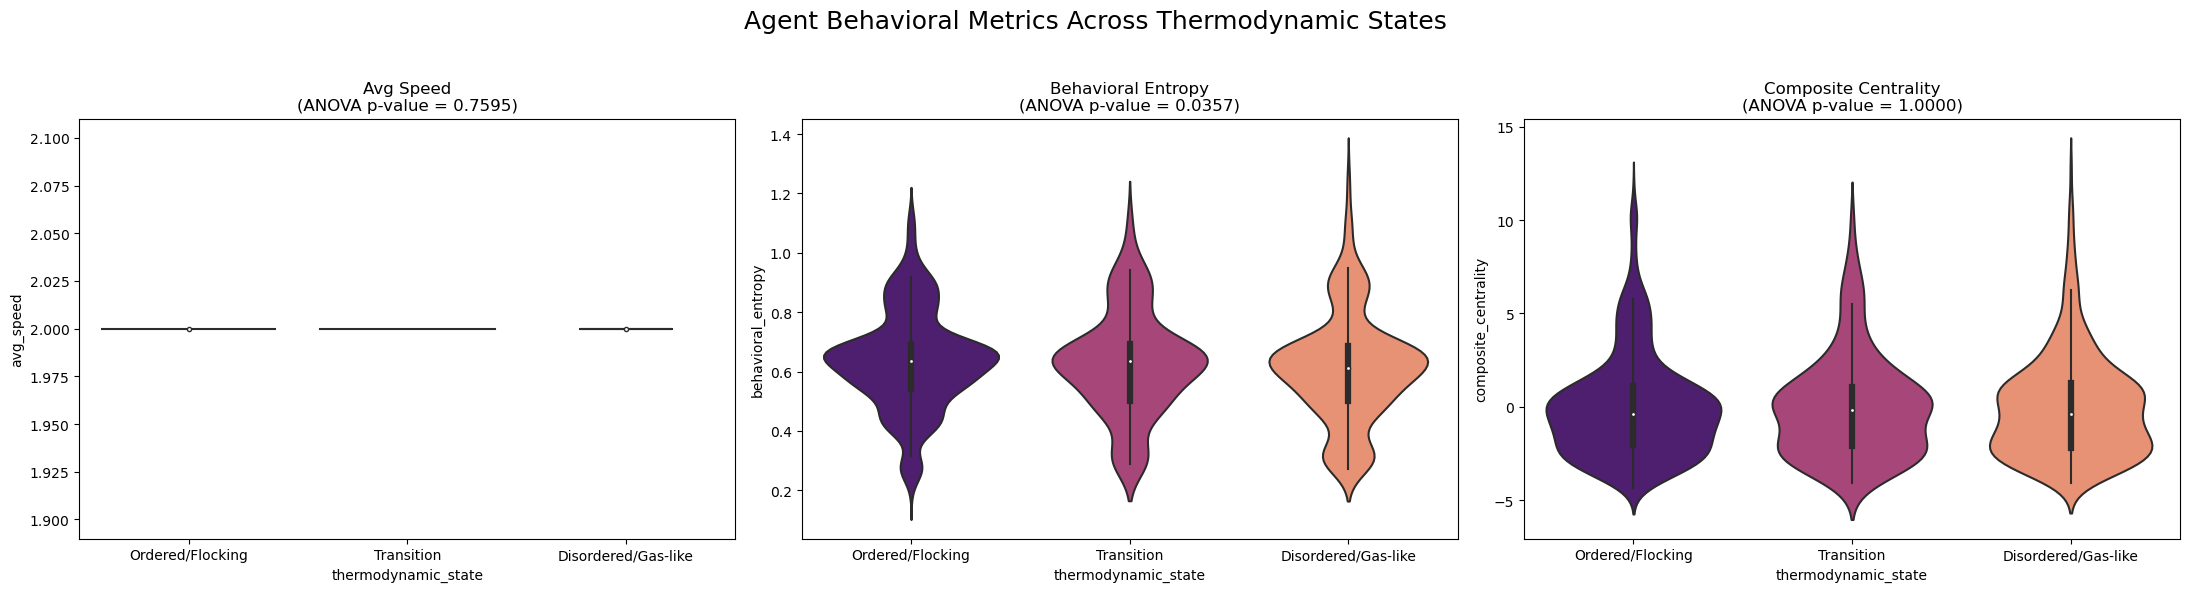


--- ANOVA 2: How Do Role and State Interact to Affect Influence? ---
Two-Way ANOVA Results for `composite_centrality`:
                                     sum_sq      df            F  \
C(role)                         7588.640884     1.0  2376.194354   
C(thermodynamic_state)             0.038191     2.0     0.005979   
C(role):C(thermodynamic_state)     2.119540     2.0     0.331841   
Residual                        5275.845690  1652.0          NaN   

                                       PR(>F)  
C(role)                         4.594811e-322  
C(thermodynamic_state)           9.940386e-01  
C(role):C(thermodynamic_state)   7.176495e-01  
Residual                                  NaN  


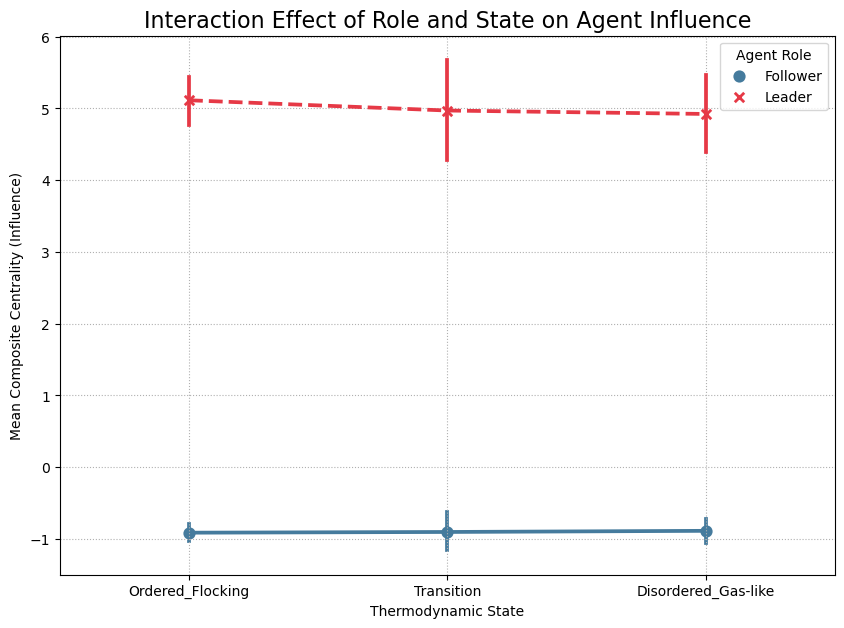

In [110]:
# =============================================================================
# 3. MAIN EXECUTION SCRIPT
# =============================================================================
if __name__ == '__main__':
    # Load the definitive dataset
    velocities, positions, thermo_data = load_decentralized_data()
    
    # STEP 1: Classify all 45,000 timesteps across all simulations
    state_labels_df = classify_thermodynamic_states(thermo_data, n_clusters=4)
    
    # STEPS 2, 3, 4: Analyze leadership within each simulation and state
    print("\n--- Analyzing Leadership for a Subset of Simulations for In-depth Study ---")
    # To make this computationally feasible, we analyze a subset of the 300 simulations
    SIMS_TO_ANALYZE = 100
    master_agent_df = []
    
    # ...existing code...
    # ...existing code...
for sim_idx in tqdm(range(SIMS_TO_ANALYZE), desc="Analyzing Simulations"):
    sim_velocities = velocities[sim_idx]
    sim_states = state_labels_df.iloc[sim_idx].values  # shape: (timesteps,)

    # Analyze each contiguous block of the same state
    prev_state = sim_states[0]
    start_idx = 0
    for t in range(1, len(sim_states)):
        if sim_states[t] != prev_state or t == len(sim_states) - 1:
            end_idx = t if sim_states[t] != prev_state else t + 1
            if end_idx - start_idx < 10:  # skip very short segments
                prev_state = sim_states[t]
                start_idx = t
                continue
            seg_velocities = sim_velocities[start_idx:end_idx]
            G = compute_influence_network(seg_velocities)
            centrality_df = calculate_centralities_and_roles(G)
            if centrality_df.empty or centrality_df['role'].nunique() < 2:
                prev_state = sim_states[t]
                start_idx = t
                continue

            # --- Additional Network Metrics ---
            # Betweenness centrality (for directed graphs)
            betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
            centrality_df['betweenness'] = [betweenness.get(i, 0.0) for i in centrality_df.index]

            # Clustering coefficient (for directed graphs, uses undirected version)
            clustering = nx.clustering(G.to_undirected(), weight='weight')
            centrality_df['clustering'] = [clustering.get(i, 0.0) for i in centrality_df.index]

            # Local efficiency (for undirected graphs)
            local_eff = nx.local_efficiency(G.to_undirected())
            centrality_df['local_efficiency'] = local_eff  # This is a single value for the whole graph

            avg_speeds = np.linalg.norm(seg_velocities, axis=2).mean(axis=0)
            centrality_df['avg_speed'] = [avg_speeds[i] for i in centrality_df.index]
            d_speeds = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(np.linalg.norm(seg_velocities, axis=2))
            entropies = [entropy(np.bincount(d_speeds[:, i].astype(int))) for i in range(seg_velocities.shape[1])]
            centrality_df['behavioral_entropy'] = [entropies[i] for i in centrality_df.index]
            centrality_df['thermodynamic_state'] = prev_state
            master_agent_df.append(centrality_df)
            prev_state = sim_states[t]
            start_idx = t

# STEP 5: Perform the final statistical validation
if master_agent_df:
    final_df = pd.concat(master_agent_df, ignore_index=True)
    perform_statistical_validation(final_df)
else:
    print("\n❌ Analysis could not be completed.")



In [111]:
local_eff_per_node = {n: nx.local_efficiency(G.subgraph(G.neighbors(n)).to_undirected()) for n in G.nodes()}
centrality_df['local_efficiency'] = [local_eff_per_node.get(i, 0.0) for i in centrality_df.index]

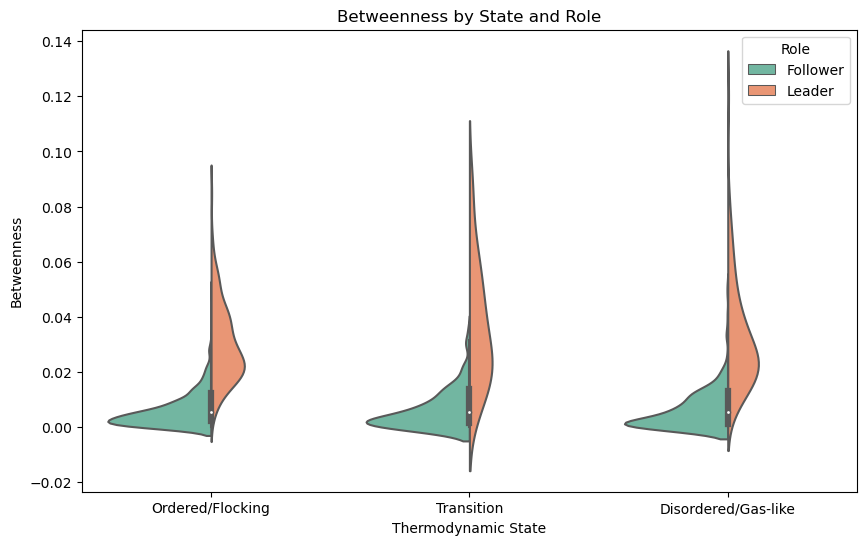

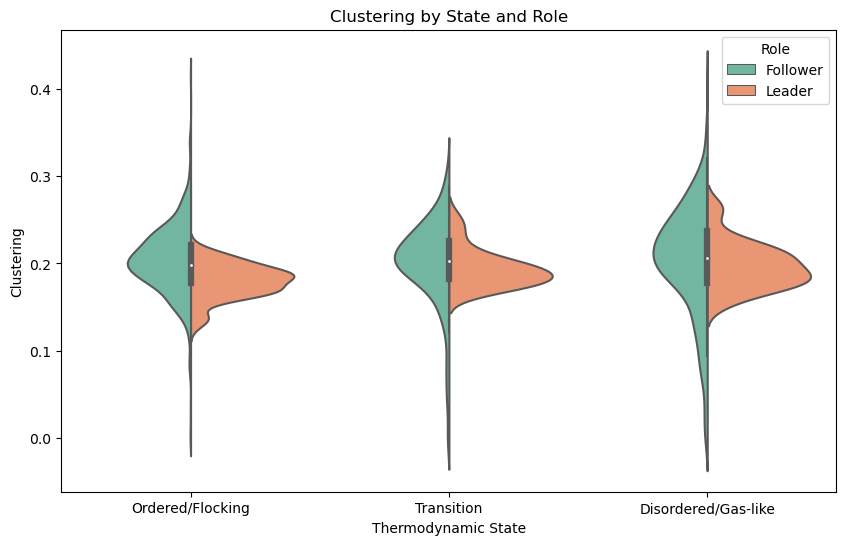

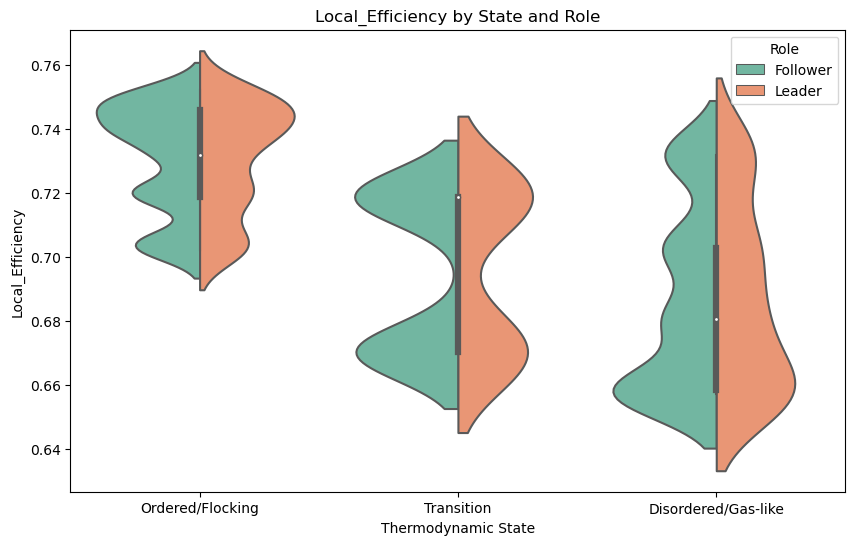

In [112]:
# Visualize network metrics across thermodynamic states and roles
metrics = ['betweenness', 'clustering', 'local_efficiency']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='thermodynamic_state', y=metric, hue='role', data=final_df,
                   order=["Ordered/Flocking", "Transition", "Disordered/Gas-like"],
                   split=True, palette="Set2")
    plt.title(f'{metric.title()} by State and Role')
    plt.xlabel('Thermodynamic State')
    plt.ylabel(metric.title())
    plt.legend(title='Role')
    plt.show()

In [114]:
from scipy.stats import f_oneway

for metric in metrics:
    print(f"\nANOVA for {metric}:")
    groups = [g[metric].dropna() for name, g in final_df.groupby('thermodynamic_state')]
    if len(groups) > 1:
        f_stat, p_val = f_oneway(*groups)
        print(f"F = {f_stat:.3f}, p = {p_val:.4g}")


ANOVA for betweenness:
F = 0.699, p = 0.4974

ANOVA for clustering:
F = 0.791, p = 0.4538

ANOVA for local_efficiency:
F = 749.902, p = 1.431e-232


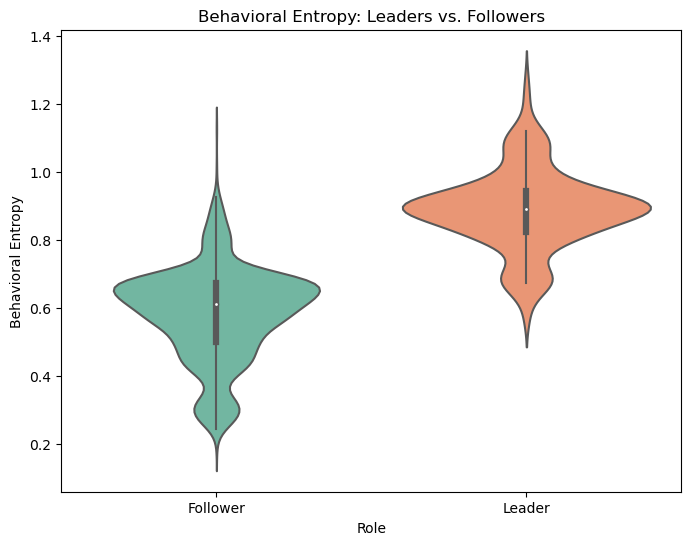

T-test: t = 37.393, p = 1.012e-130
Leaders and followers have significantly different behavioral entropy.
Mean entropy (Leaders): 0.889
Mean entropy (Followers): 0.583


In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# 1. Boxplot/violinplot of behavioral entropy by role
plt.figure(figsize=(8,6))
sns.violinplot(x='role', y='behavioral_entropy', data=final_df, palette='Set2')
plt.title('Behavioral Entropy: Leaders vs. Followers')
plt.xlabel('Role')
plt.ylabel('Behavioral Entropy')
plt.show()

# 2. Statistical test (t-test)
leaders_entropy = final_df.loc[final_df['role'] == 'Leader', 'behavioral_entropy'].dropna()
followers_entropy = final_df.loc[final_df['role'] == 'Follower', 'behavioral_entropy'].dropna()
t_stat, p_val = ttest_ind(leaders_entropy, followers_entropy, equal_var=False)

print(f"T-test: t = {t_stat:.3f}, p = {p_val:.4g}")
if p_val < 0.05:
    print("Leaders and followers have significantly different behavioral entropy.")
else:
    print("No significant difference in behavioral entropy between leaders and followers.")

# 3. (Optional) Print means for context
print(f"Mean entropy (Leaders): {leaders_entropy.mean():.3f}")
print(f"Mean entropy (Followers): {followers_entropy.mean():.3f}")

In [107]:
print(final_df['role'].unique())
print(final_df['thermodynamic_state'].unique())

['Follower' 'Leader']
['Transition' 'Ordered/Flocking' 'Disordered/Gas-like']


In [108]:
print(state_labels_df.apply(pd.Series).stack().value_counts())

Disordered/Gas-like    14668
Transition              5612
Ordered/Flocking        1787
Name: count, dtype: int64
